In [1]:
import pickle as pck
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from functions_MuonsNSAMP1 import DataFrame_muons, pdf_creator3x3, pdf_creator3x3_indexs

# from ROOT import TFile, TTree

## Configuración del estilo de las imágenes
plt.rcParams.update({
    "image.origin": "lower",
    "image.aspect": 1,
    #"text.usetex": True,
    "grid.alpha": .5,
    "axes.linewidth":2,
    "lines.linewidth" : 1,
    "font.size":    15.0,
    "xaxis.labellocation": 'right',  # alignment of the xaxis label: {left, right, center}
    "yaxis.labellocation": 'top',  # alignment of the yaxis label: {bottom, top, center}
    "xtick.top":           True ,  # draw ticks on the top side
    "xtick.major.size":    8    ,# major tick size in points
    "xtick.minor.size":    4      ,# minor tick size in points
    "xtick.direction":     'in',
    "xtick.minor.visible": True,
    "ytick.right":           True ,  # draw ticks on the top side
    "ytick.major.size":    8    ,# major tick size in points
    "ytick.minor.size":    4      ,# minor tick size in points
    "ytick.direction":     'in',
    "ytick.minor.visible": True,
    "ytick.major.width":   2   , # major tick width in points
    "ytick.minor.width":   1 ,
    "xtick.major.width":   2   , # major tick width in points
    "xtick.minor.width":   1 ,
    "legend.framealpha": 0 ,
    "legend.loc": 'best',
})

colorbar='jet'


In [2]:
######## Nueva definición de la elipcidad ############
# path = './Diccionarios_Espetro_Muones/dict_muons_NSAMP324_Extensions_1_2_4_NIMGS_393_SOL_0.65_ELIP_0.65_NSIGMAS_13_dEDL_0_SIZE_250x539_KeV_.pkl'
path = './Diccionarios_Espetro_Muones/dict_muons_NSAMP324_Extensions_1_2_4_NIMGS_393_SOL_0.65_ELIP_0.65_NSIGMAS_13_DEDL_0_SIZE_250x539_KeV_n.pkl'

histogram = open(path, 'rb')
data_histogram = pck.load(histogram)
histogram.close()

#### Visualizar las keys del diccionario ####
print('Las unidades de los datos están en: ', data_histogram['Energy_Units'])
print('Llaves principales del diccionario: ', data_histogram.keys())
print('Llaves secuandarias por extensión: ', data_histogram['extension_1'].keys(), end='\n\n')
# print(type(data_histogram['extension_1']['all_events']))
# data_muons_extension_1 = data_histogram['extension_1']
# data_muons_extension_2 = data_histogram['extension_2']
# data_muons_extension_4 = data_histogram['extension_4']
Ext = 2

n_muons = data_histogram['All_Muons_Detected']
print('Se detectaron ', n_muons, ' muones (contando las 3 extensiones)')
DF_muons, list_datamask = DataFrame_muons(data_histogram, extension=Ext)

Las unidades de los datos están en:  2
Llaves principales del diccionario:  dict_keys(['Num_Images', 'All_Muons_Detected', 'Energy_Units', 'Elipticity', 'Solidity', 'Fit_errors', 'extension_1', 'extension_2', 'extension_4'])
Llaves secuandarias por extensión:  dict_keys(['charge', 'deltaEL', 'deltaL', 'all_events', 'theta', 'phi', 'gain', 'elip', 'sol', 'all_events_elip', 'all_events_sol', 'datamasked'])

Se detectaron  4335  muones (contando las 3 extensiones)


,Gain (ADU/e-),Solidity,Elipticity,Theta (Deg),Phi (Deg),Charge (KeV),l (cm),dEdL (KeV/cm)
Muon ID,,,,,,,,
14,212.296545,0.826923,0.7474,17.325987,180.45105,7.812216,0.075946,102.86542


Shape (Y, X):  (4, 16)


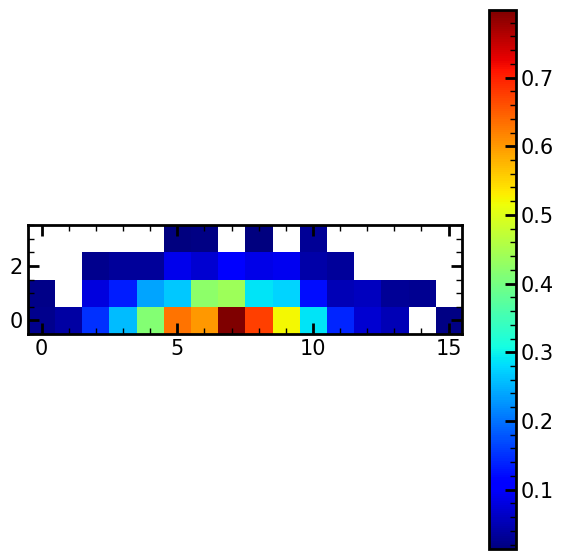

In [6]:
n_label = 14

fig, axs = plt.subplots(ncols=1, nrows=1, figsize=[7,7])
x1 = axs.imshow(list_datamask[n_label], cmap=colorbar)
fig.colorbar(x1, ax=axs)

display(DF_muons.iloc[[n_label]])
print('Shape (Y, X): ', list_datamask[n_label].shape)
plt.show()

In [5]:
Ext = 1
DF_muons, list_datamask = DataFrame_muons(data_histogram, extension=Ext)

list_newmatrix = []
list_indexs =[]
range_in_phi = DF_muons[DF_muons['Phi (Deg)'].between(165, 195)]
for index in range_in_phi.index:
    print(index)
    list_newmatrix.append(list_datamask[index])
    list_indexs.append(index)

# plt.imshow(list_newmatrix[0])
PDF_name = 'Muons_PHI_BETWEEN_165-195_EXT1.pdf'
pdf_creator3x3_indexs(PDF_name, list_newmatrix, list_indexs)


1
7
8
14
17
35
36
39
49
53
58
65
69
70
79
96
97
109
131
136
138
141
142
147
148
161
166
177
178
183
185
191
195
198
201
202
208
210
221
224
228
230
251
252
260
261
277
284
287
295
297
305
308
314
333
335
337
351
359
365
366
367
379
383
386
394
395
399
419
427
428
446
456
461
471
475
476
489
509
520
534
551
558
566
569
574
575
576
577
578
580
581
588
589
593
600
601
606
608
615
619
621
622
632
638
643
649
652
654
655
658
659
661
662
671
682
685
687
691
693
700
702
703
708
710
713
714
723
724
725
727
729
732
746
765
769
770
771
772
775
777
780
781
787
798
800
809
817
819
820
821
825
827
828
829
830
832
839
840
846
847
851
855
860
863
871
872
874
877
880
881
882
885
887
890
891
906
909
913
918
925
934
941
944
953
955
958
962
963
964
965
966
968
971
979
980
982
984
989
990
998
1002
1025
1034
1037
1039
1042
1045
1047
1048
1050
1054
1055
1064
1072
1077
1081
1084
1092
1093
1094
1102
1105
1109
1110
1111
1112
1118
1120
1123
1124
1128
1131
1133
1141
1146
1150
1156
1164
1165
1173
1176
1178
1180
1

0

# Creación de PDF para todos los muones de una extensión

In [ ]:
n_label = 100

fig, axs = plt.subplots(ncols=3, nrows=3, figsize=[7,7])
axs[0,0].imshow(list_datamask[n_label], cmap=colorbar)
axs[0,0].set_title('ID: ' + str(n_label))

axs[0,1].imshow(list_datamask[n_label+1], cmap=colorbar)
axs[0,1].set_title('ID: ' + str(n_label+1))

axs[0,2].imshow(list_datamask[n_label+2], cmap=colorbar)
axs[0,2].set_title('ID: ' + str(n_label+2))

axs[1,0].imshow(list_datamask[n_label+3], cmap=colorbar)
axs[1,0].set_title('ID: ' + str(n_label+3))

axs[1,1].imshow(list_datamask[n_label+4], cmap=colorbar)
axs[1,1].set_title('ID: ' + str(n_label+4))

axs[1,2].imshow(list_datamask[n_label+5], cmap=colorbar)
axs[1,2].set_title('ID: ' + str(n_label+5))

axs[2,0].imshow(list_datamask[n_label+6], cmap=colorbar)
axs[2,0].set_title('ID: ' + str(n_label+6))

axs[2,1].imshow(list_datamask[n_label], cmap=colorbar)
axs[2,1].set_title('ID: ' + str(n_label+7))

axs[2,2].imshow(list_datamask[n_label+8], cmap=colorbar)
axs[2,2].set_title('ID: ' + str(n_label+8))

plt.tight_layout()
plt.show()

In [ ]:
Ext = 1  # Only change this value and the PDF_name

DF_muons, list_datamask = DataFrame_muons(data_histogram, extension=Ext)

# list_datamask = list_datamask[:50]
print('Len: ', len(list_datamask))
### Creación del PDF con el nombre ##
PDF_name = 'Prueba1.pdf'
c = canvas.Canvas(PDF_name, letter)
w, h = A4 ## dimensiones del formato

### Imagen provicional ###
path_image = 'Perfil_Muon.jpg'
color_matrix = [0.4, 0.4470, 0.2410]
coord3x3 = [[0,0],[0,1], [0,2], [1,0], [1,1], [1,2], [2,0], [2,1], [2,2]]
n_last_events = 0

# for extension in (1,2,4):
# c.drawString(50, h - 50, 'Extensión ' + str(Ext)) 
n_muonstot = len(list_datamask)
n_last_events = 0
n_events = 0


fig, axs = plt.subplots(ncols= 3, nrows= 3, figsize = [6,6], facecolor = color_matrix) ## Las hojas tendrán 9 muones
num_pages = 0
# c.showPage()

if (n_muonstot%9) == 0:
    # print('Hola')
    for index in range(0, len(list_datamask)):
        n_muonstot = n_muonstot - 1
        n_events = n_events + 1
        if n_events < 10: 
            # print('n_events: ', n_events)
            axs[coord3x3[n_events - 1][0],coord3x3[n_events - 1][1]].imshow(list_datamask[index], cmap = colorbar)
            axs[coord3x3[n_events - 1][0],coord3x3[n_events - 1][1]].set_title('ID: ' + str(index))

            if n_events == 9:
                n_events = 10
        
        if n_events == 10:
            n_events = 0
            num_pages = num_pages + 1
            fig.savefig(path_image)
            img = ImageReader(path_image)

            # Obtener el ancho y alto de la imagen.
            img_w, img_h = img.getSize()

            # h - img_h es el alto de la hoja menos el alto de la imagen.
            c.drawImage(img, w - img_w + 10, h - img_h - 90)
            c.drawString(w/2, 40, str(num_pages))
            c.showPage()
            # plt.imshow(event)
            # plt.show()
            plt.close()
            ! rm Perfil_Muon.jpg

            fig, axs = plt.subplots(ncols= 3, nrows= 3, figsize = [6,6], facecolor = color_matrix)

elif (n_muonstot%9) != 0:
    # print('No Hola')
    Resto = n_muonstot%9

    for index in range(0, len(list_datamask)):
        n_muonstot = n_muonstot - 1
        n_events = n_events + 1

        if n_muonstot >= Resto:
            print('Primera condicion')
            if n_events < 10: 
                # print('n_events: ', n_events)
                axs[coord3x3[n_events - 1][0],coord3x3[n_events - 1][1]].imshow(list_datamask[index], cmap = colorbar)
                axs[coord3x3[n_events - 1][0],coord3x3[n_events - 1][1]].set_title('ID: ' + str(index))

                if n_events == 9:
                    n_events = 10

            if n_events == 10:
                print('Estoy aqui')
                n_events = 0
                num_pages = num_pages + 1
                fig.savefig(path_image)
                img = ImageReader(path_image)

                # Obtener el ancho y alto de la imagen.
                img_w, img_h = img.getSize()
                print('Aqui ', img_w)

                # h - img_h es el alto de la hoja menos el alto de la imagen.
                c.drawImage(img, w - img_w+10, h - img_h-90)
                c.drawString(w/2, 40, str(num_pages))
                c.showPage()
                # plt.imshow(event)
                # plt.show()
                plt.close()
                ! rm Perfil_Muon.jpg

                fig, axs = plt.subplots(ncols= 3, nrows= 3, figsize = [6,6], facecolor = color_matrix)

        elif n_muonstot<Resto:
            print('Segunda condicion')
            n_last_events = n_last_events + 1

            axs[coord3x3[n_last_events - 1][0],coord3x3[n_last_events - 1][1]].imshow(list_datamask[index], cmap=colorbar)
            axs[coord3x3[n_last_events - 1][0],coord3x3[n_last_events - 1][1]].set_title('ID: ' + str(index))

            if n_muonstot == 0:
                # plt.show()
                num_pages = num_pages + 1
                fig.savefig(path_image)
                img = ImageReader(path_image)

                # Obtener el ancho y alto de la imagen.
                img_w, img_h = img.getSize()

                # h - img_h es el alto de la hoja menos el alto de la imagen.
                c.drawImage(img, w - img_w + 50, h - img_h - 60)
                c.drawString(w/2, 40, str(num_pages))
                c.showPage()
                # plt.imshow(event)
                # plt.show()
                plt.close()
                ! rm Perfil_Muon.jpg

                fig, axs = plt.subplots(ncols= 3, nrows= 3, figsize = [10,10], facecolor = color_matrix)
        
plt.close()
c.save()

Len:  1361
No Hola
Primera condicion
Primera condicion
Primera condicion
Primera condicion
Primera condicion
Primera condicion
Primera condicion
Primera condicion
Primera condicion
Estoy aqui
Aqui  600
Primera condicion
Primera condicion
Primera condicion
Primera condicion
Primera condicion
Primera condicion
Primera condicion
Primera condicion
Primera condicion
Estoy aqui
Aqui  600
Primera condicion
Primera condicion
Primera condicion
Primera condicion
Primera condicion
Primera condicion
Primera condicion
Primera condicion
Primera condicion
Estoy aqui
Aqui  600
Primera condicion
Primera condicion
Primera condicion
Primera condicion
Primera condicion
Primera condicion
Primera condicion
Primera condicion
Primera condicion
Estoy aqui
Aqui  600
Primera condicion
Primera condicion
Primera condicion
Primera condicion
Primera condicion
Primera condicion
Primera condicion
Primera condicion
Primera condicion
Estoy aqui
Aqui  600
Primera condicion
Primera condicion
Primera condicion
Primera cond